# Sentiment Analysis

1. Scaled representation of : `pos`, `neg`, `neutral` [done]
2. Aspect-based analysis: which particular aspects or features are mentioned in a positive, neutral, or negative way. []
3. Semantic Clustering []
4. Feature Analysis []
5. Aspect Similaarity co-occurance
6. Emotion aspect co-occurance

   ======

1. Overall sentiment [done]
2. Sentiment by floor and space [done]
3. Sentiment by type of space i.e. group vs individual [done]
4. Sentiment by topic

In [1]:
import string
import re

import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
import spacy

from collections import Counter

from textblob import TextBlob
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn.functional as F
from transformers import pipeline
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize


# Settings
sns.set_style("whitegrid", {'axes.grid' : False})
nlp = spacy.load("en_core_web_sm")


In [ ]:
drop_col_emo=['occupation', 'usage', 'recruitment']

# Students at LAB42

In [ ]:
emo_sl42 = pd.read_csv('data/lab42_cleaned_data.csv', index_col=0).drop(columns = drop_col_emo, axis=1).dropna(subset=['emotion'])

## Emotions: LLM-based Overall Sentiment Analysis

In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
sentiment_task = pipeline("sentiment-analysis", model=MODEL, tokenizer=MODEL)

In [ ]:
def sentiment_analysis(sentence):
    return sentiment_task(sentence, top_k=3)

def assign_scores(idx):
    emo_sl42.at[idx, 'positive'] = next(item for item in emo_sl42['senti'][idx] if item['label'] == 'positive')['score']
    emo_sl42.at[idx, 'negative'] = next(item for item in emo_sl42['senti'][idx] if item['label'] == 'negative')['score']
    emo_sl42.at[idx, 'neutral'] = next(item for item in emo_sl42['senti'][idx] if item['label'] == 'neutral')['score']

def plot_sentiment_analysis(df, label):
    sns.countplot(y=df[label + "_label"], 
                  palette=['#b2d8d8',"#008080", '#db3d13'],
                  order=["positive", "negative", "neutral"])
    plt.ylabel("Overall Sentiment for Emotion Responses")
    plt.xlabel("Count")
    plt.savefig('plots/sentiment-analysis/students-lab42/' + label + '-llm-sentiment-count.jpg',
                dpi=300, bbox_inches='tight')

In [ ]:
# 1. Calculate sentiment analysis on each emotion statement:
emo_sl42['senti'] = emo_sl42['emotion'].apply(sentiment_analysis)

# 2. Sort Sentiment Scores into Independent Columns
for idx in emo_sl42.index:
    assign_scores(idx)

# 3. Drop Unecessary Columns
emo_sl42 = emo_sl42.drop(columns=['senti'])

# 4. Calculate the dominant overall sentiment of the response
emo_sl42['emo_label'] = emo_sl42[['positive', 'negative', 'neutral']].idxmax(axis=1)

# 5. Plot the overall sentiments distribution
plot_sentiment_analysis(emo_sl42, 'emo')

## Comfort: LLM-based Overall Sentiment Analysis

In [ ]:
comfort_sl42 = pd.read_csv('data/lab42_cleaned_data.csv', index_col=0).drop(columns = drop_col_emo, axis=1).dropna(subset=['comfort'])

In [ ]:
def sentiment_analysis(sentence):
    return sentiment_task(sentence, top_k=3)

def assign_scores(idx):
    comfort_sl42.at[idx, 'positive'] = next(item for item in comfort_sl42['senti'][idx] if item['label'] == 'positive')['score']
    comfort_sl42.at[idx, 'negative'] = next(item for item in comfort_sl42['senti'][idx] if item['label'] == 'negative')['score']
    comfort_sl42.at[idx, 'neutral'] = next(item for item in comfort_sl42['senti'][idx] if item['label'] == 'neutral')['score']

def plot_sentiment_analysis(df, label):
    sns.countplot(y=df[label + "_label"], 
                  palette=['#b2d8d8',"#008080", '#db3d13'],
                  order=["positive", "negative", "neutral"])
    plt.ylabel("Overall Sentiment for Comfort Responses")
    plt.xlabel("Count")
    plt.savefig('plots/sentiment-analysis/students-lab42/' + label + '-llm-sentiment-count.jpg',
                dpi=300, bbox_inches='tight')

In [ ]:
# 1. Calculate sentiment analysis on each emotion statement:
comfort_sl42['senti'] = comfort_sl42['comfort'].apply(sentiment_analysis)

# 2. Sort Sentiment Scores into Independent Columns
for idx in comfort_sl42.index:
    assign_scores(idx)

# 3. Drop Unecessary Columns
comfort_sl42 = comfort_sl42.drop(columns=['senti'])

# 4. Calculate the dominant overall sentiment of the response
comfort_sl42['comfort_label'] = comfort_sl42[['positive', 'negative', 'neutral']].idxmax(axis=1)

# 5. Plot the overall sentiments distribution
plot_sentiment_analysis(comfort_sl42, 'comfort')

# Comparing Emotion and Comfort Sentiments
How do positive emotion labels impact comfort? What about negative emo labels? Is there any relationship between the two?

In [ ]:
df = pd.read_csv('data/lab42_cleaned_data.csv', index_col=0)
df = df[["emotion", "comfort"]].dropna(how="any")

In [ ]:
def sentiment_analysis(sentence):
    return sentiment_task(sentence)
    
df_senti = df.applymap(sentiment_analysis)

In [ ]:
df.head()

In [ ]:
df_senti = df_senti.rename(columns={'emotion':'emo_label',
                         'comfort': 'comfort_label'})

In [ ]:
df = df_senti.join(df)

In [ ]:
df.head()

In [ ]:
def assign_labels(idx):
    # print(idx)
    # print(df['emotion'][idx][0]['label'])
    df['emo_label'][idx] = df['emo_label'][idx][0]['label']
    df['comfort_label'][idx] =  df['comfort_label'][idx][0]['label']

In [ ]:
for idx in df.index:
   assign_labels(idx)

In [ ]:
df[['emo_label', 'comfort_label']] = df[['emo_label', 'comfort_label']].replace({'positive': 1, 
                                                                                 'negative': -1,
                                                                                 'neutral': 0})

In [ ]:
df[['emo_label', 'comfort_label']].value_counts()

In [ ]:
grouped = df.groupby(['emo_label', 'comfort_label']).size().unstack(fill_value=0)

# Reset the index to use 'Emotion' as a column
grouped = grouped.reset_index()

# Melt the data to create a tidy format for Seaborn
melted = pd.melt(grouped,
                 id_vars=['emo_label'],
                 value_vars=[-1, 0, 1],
                 var_name='comfort_label',
                 value_name='Count')

# Map comfort values to colors
comfort_colors = {-1: 'red', 0: 'gray', 1: 'green'}
melted['Comfort_color'] = melted['comfort_label'].map(comfort_colors)

labels = ['Negative', 'Neutral', 'Positive']

# Create a grouped bar plot using Seaborn
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=melted, x='emo_label', y='Count', hue='comfort_label')
plt.xlabel('Emotion Sentiments')
ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
plt.ylabel('Count')
plt.title('Relationship between Emotion and Comfort Sentiment Labels')

h, l = ax.get_legend_handles_labels()
ax.legend(h, labels, title='Comfort Sentiments')
plt.savefig('plots/emotion-vs-comfort-sentiments.jpg',
            dpi=300, bbox_inches='tight')

## Overview of Relationship between Emotions and Comfort
Positive emotion --> positive comfort (N=52) 42%

Positive emotion --> neutral comfort (N=16) 13%

Neutral emotion --> positive comfort (N=22) 18%

Very rare that positive emotions --> negative comfort (N=4) 0.03%

Very rare that negative emotions --> positive comfort (N=4) 0.03%

Very rare that neutral emotions --> negative or neutral comfort (N=6/5)

In [ ]:
for row in df[(df['emo_label']== -1) & (df['comfort_label'] == 1)].comfort:
    print("*: ", row)

In [ ]:
for row in df[(df['emo_label']== 1) & (df['comfort_label'] == -1)].comfort:
    print("*: ", row)

In [ ]:
for row in df[(df['emo_label']== 0) & (df['comfort_label'] == -1)].comfort:
    print("*: ", row)

## Lexicon-based Analysis using VADER
Here we are interested in the rule-based analysis. The compound score is computed by summing the 
valence scores of each word in the lexicon, adjusted according to the rules, and then normalized 
to be between -1 (most extreme negative) and +1 (most extreme positive). 
It is a 'normalized, weighted composite score.

In [ ]:
def vader_lexicon_analysis(df, label):
    analyzer = SentimentIntensityAnalyzer()
    df[label + '-composite-score'] = df[label].apply(lambda x: analyzer.polarity_scores(str(x))['compound'])
    
    return df 

def plot_lexicon_analysis(df, label):
    sns.boxplot(x='floor', y='emotion-composite-score', data=df)
    plt.xlabel("Floor")
    plt.ylabel("Lexicon-based Normalised Weighted Composite Score \n (1 = Most Positive; 0 = Neutral; -1 = Most Negative)")
    plt.tick_params(bottom=False)
    plt.axhline(0, ls='--', c = 'grey')
    plt.savefig('plots/sentiment-analysis/students-lab42/' +
                label +
                '-vader-lexicon-composite.jpg',
                dpi=300,
                bbox_inches='tight')

    plt.clf()

    sns.displot(x='emotion-composite-score', kde=True, 
                height=4,
                aspect=1.5,
                data=emo_sl42)
    plt.xlabel("Lexicon-Based Normalised Weighted Composite Scores for Sentiments \n (1 = Most Positive; 0 = Neutral; -1 = Most Negative)")
    plt.tick_params(bottom=False)
    plt.axhline(0, ls='--', c = 'grey')
    plt.savefig('plots/sentiment-analysis/students-lab42/' +
                label +
                '-distribution-lexicon-composite.jpg',
                dpi=300,
                bbox_inches='tight')
    plt.clf()

    sns.displot(x='emotion-composite-score', y='emo_label',
                binwidth=(.2, .1),
                height=4,
                aspect=1.5,
                data=emo_sl42)
    plt.xlabel("Lexicon-Based Normalised Weighted Composite Scores for Sentiments \n (1 = Most Positive; 0 = Neutral; -1 = Most Negative)")
    plt.ylabel("LLM Generated Sentiment Labels")
    plt.tick_params(bottom=False)
    plt.savefig('plots/sentiment-analysis/students-lab42/' +
                label +
                '-vader-vs-lexicon-composite.jpg',
                dpi=300,
                bbox_inches='tight')

def plot_sentiment_analysis_spaces(df, label):
    df = df.where(df["space-type"] != "").dropna(how="all")
    f = plt.figure(figsize=(10, 6))
    sns.boxplot(x='space-type', y='compound', width=0.5,
 data=df)
    plt.xlabel("Space Type")
    plt.ylabel("Sentiment Value \n (1 = Most Positive; 0 = Neutral; -1 = Most Negative)")
    plt.tick_params(bottom=False)
    plt.axhline(0, ls='--', c = 'grey')
    plt.savefig('plots/lab42-' + label + '-space-wise-sentiment-distribution.jpg',
                dpi=300, bbox_inches='tight')

In [ ]:
emo_sl42 = vader_lexicon_analysis(emo_sl42, 'emotion')
plot_lexicon_analysis(emo_sl42, 'emotion')

## Scale data to scores between -1 and 1
Polarity score in the range of -1 to -0.5 typically indicates negative sentiment
Polarity score greater than -0.5 and less than +0.5 typically indicates neutral sentiment
Polarity score in the range of +0.5 to 1 typically indicates positive sentiment

In [ ]:
def scale_emotion_values():
    labels = ['positive', 'negative', 'neutral']
    scales = [(0.5, 1.0), (-1.0, -0.5), (-0.5, 0.5)]
    emo_sl42['scaled_scores'] = 0
    
    for label, scale in zip(labels, scales):
        values = np.array(emo_sl42[label][emo_sl42['emo_label'] == label]).reshape(-1,1)
        idx = emo_sl42.index[emo_sl42['emo_label'] == label].to_list()
        scaled_values = minmax_scaler(scale, values, idx)
        emo_sl42.loc[idx,'scaled_scores'] = scaled_values
    
    return emo_sl42


def minmax_scaler(scale, values, idx):
    scaler = MinMaxScaler(feature_range = scale)
    scaled_values = pd.Series(scaler.fit_transform(values).flatten()).set_axis(idx)
    
    return scaled_values 

In [ ]:
emo_sl42 = scale_emotion_values()

In [ ]:
group = ['Round tables by the three plants (across wooden staircase)',
                        'Next to the lockers',
                        'Study corner next to the plant wall',
                        'Yellow/white chairs & tables (besides the wooden staircase)',
                        'Tables on the landing (with wooden floor) accessible by the black staircase',
                        'Green group study tables (between a row of plants and railing)',
                        'Group tables by the stairs',
                        'Open lounge area',
                        'Near the printer',
                        'Round tables by the coffee machine']

individual =  ['Library learning room',
                             'Green chairs by the entrance',
                             'Partly covered green chairs (along glass wall)']

unsure = ["Unsure"]

def assign_types_to_spaces(space):
    if space in group:
        return "group"
    if space in individual:
        return "individual"
    if space in unsure:
        return "unsure"
    
def merge_spaces(df):
    df["space-type"] = df["space-ground-floor"] + df["space-1-floor"] + df["space-2-floor"] + df["space-3-floor"]
    df = df.drop(columns =["space-ground-floor", "space-1-floor", "space-2-floor", "space-3-floor"])
    
    return df


def create_group_solo_space_labels(df):
    spaces = ["ground-floor", "1-floor", "2-floor", "3-floor"]
    
    for space in spaces:
        df["space-" + space] = df[space].apply(lambda space: assign_types_to_spaces(space)).fillna("")
    
    return df


def plot_sentiment_analysis_spaces(df, label):
    df = df.where(df["space-type"] != "").dropna(how="all")
    f = plt.figure(figsize=(10, 6))
    sns.boxplot(x='space-type', y='scaled_scores',
                width=0.5,
                data=df)
    plt.xlabel("Space Type")
    plt.ylabel("Sentiment Value \n (1 = Most Positive; 0 = Neutral; -1 = Most Negative)")
    plt.tick_params(bottom=False)
    plt.axhline(0, ls='--', c = 'grey')
    plt.savefig('plots/lab42-' + label + '-space-wise-sentiment-distribution.jpg',
                dpi=300, bbox_inches='tight')

In [ ]:
df = create_group_solo_space_labels(emo_sl42)
df = merge_spaces(df)
plot_sentiment_analysis_spaces(df, 'emotion')

In [ ]:
def plot_overview_sentiment_analysis_spaces(df, label):
    df = df.where(df["space-type"] != "").dropna(how="all")
    f = plt.figure(figsize=(10, 6))
    sns.catplot(data=df, 
                x="floor", y='scaled_scores',
                hue="emo_label",
                col="space-type",
                kind="swarm" )
    plt.xlabel("Floor")
    plt.ylabel("Scaled Sentiment Value \n (1 = Most Positive; 0 = Neutral; -1 = Most Negative)")
    plt.tick_params(bottom=False)
    plt.savefig('plots/lab42-' + label + 'floor-space-wise-sentiment-distribution.jpg',
                dpi=300, bbox_inches='tight')



# sns.countplot(y=emo_sl42["emo_label"], palette=['#b2d8d8',"#008080", '#db3d13'],order=["positive", "negative", "neutral"])

In [ ]:
plot_overview_sentiment_analysis_spaces(emo_sl42, "emo")

In [ ]:
emo_sl42['dominant_emo_val'] = emo_sl42[['positive', 'negative', 'neutral']].max(axis=1)


In [ ]:
sns.catplot(x='emo_label', y='dominant_emo_val', hue="space-type",
            kind="bar", errorbar=None, data=emo_sl42)

# Aspect-Based Sentiment Analysis

maybe train your own model: https://github.com/shwe24/Aspect-Based-Sentiment-Classification/blob/main/Aspect_Extraction.ipynb

In [13]:
df = pd.read_csv('data/lab42_cleaned_data.csv', index_col=0)
# df = df[["emotion"]].dropna(how="any")
df = df[["comfort"]].dropna(how="any")

In [3]:
# Load Aspect-Based Sentiment Analysis model
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
sentiment_task = pipeline("sentiment-analysis", model=MODEL, tokenizer=MODEL)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
emotion_aspect = ["calm"]
# comfort_aspect = ["noise", "air", "temperature", "light"]
# biophilic_aspect = [""]

In [37]:
comfort_aspect = {
    "noise": [
        "noise", "noisy", "loud", "quiet", "silence", "sound",
        "disturbance", "cacophony", "ambient noise", "quietness"
    ]
    ,
    "air": [
        "air", "air quality", "ventilation", "fresh air", "stuffy",
        "odor", "fragrance", "pollution", "breathable", "circulation"
    ],
    "temperature": [
        "temperature", "warm", "hot", "cold",
        "chilly", "thermostat", "climate", "cozy", "freezing",
        "pleasant"
    ],
    "light": [
        "light", "lighting", "bright", "dim", "natural light",
        "illumination", "dark", "glare", "luminosity", "gloomy",
        "sun", "cloudy"
    ]
}

In [38]:
def sentiment_analysis(sentence):
    return sentiment_task(sentence)

def clean_strings(str):
    str = str.translate(str.maketrans({"’":None}))
    return str.translate(str.maketrans ('', '', string.punctuation))

### Calm:


In [ ]:
df['emotion'] = df['emotion'].apply(clean_strings)

df['aspects'] = ''

# Process each row in the DataFrame
for index, row in df.iterrows():
    doc = nlp(row['emotion'])
    aspects = []

    for token in doc:
        if token.text.lower() in emotion_aspect:            
            aspect = token.text
            context = ' '.join([t.text for t in doc[token.i - 3:token.i + 4]])  # Extract 3 words before and after the aspect
            sentiment = sentiment_analysis(context)
            aspects.append(context)
            df.at[index, 'aspect_key'] = aspect
            df.at[index, 'aspect_sentiment'] = sentiment
    df.at[index, 'aspects'] = aspects

In [ ]:
# Initialize a dictionary to store extracted sentiment scores for each aspect
aspect_scores = {}

# Iterate through the rows and extract sentiment scores for each aspect
for row in df['aspect_sentiment']:
    if isinstance(row, list):
        for sentiment in row:
            label = sentiment['label']
            score = sentiment['score']
            aspect_scores[label] = aspect_scores.get(label, []) + [score]

# Create box plots for sentiment scores of each aspect
plt.figure(figsize=(10, 6))
plt.boxplot(aspect_scores.values(), labels=aspect_scores.keys(), vert=False, patch_artist=True)
plt.ylabel('Sentiment Label')
plt.xlabel('Sentiment Score (0.0 - 1.0)')
plt.title('Aspect Sentiment Distribution')
plt.show()

In [ ]:
def generate_wordcloud():
    df['aspects'] = [''.join(map(str, l)) for l in df['aspects']]
    df['aspects'].str.cat(sep=' ')  
    wordcloud = WordCloud(background_color="white").generate(df['aspects'].str.cat(sep=' '))

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [ ]:
generate_wordcloud()

### Comfort

In [39]:
df['comfort'] = df['comfort'].apply(clean_strings)

In [40]:
# Initialize Porter Stemmer
stemmer = PorterStemmer()

In [41]:
stemmed_comfort_aspect = {}
for aspect, words in comfort_aspect.items():
    stemmed_words = [stemmer.stem(word) for word in words]
    stemmed_comfort_aspect[aspect] = stemmed_words

In [42]:
def extract_context(text, aspect, window_size=3):
    tokens = word_tokenize(text)
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    
    aspect_indices = [i for i, token in enumerate(stemmed_tokens) if token == aspect]
    
    contexts = []        
    
    for token in stemmed_tokens:
        if token in stemmed_comfort_aspect[aspect]:
            start_index = max(0, stemmed_tokens.index(token) - 3)
            end_index = min(len(stemmed_tokens), stemmed_tokens.index(token) + 4)
            context = ' '.join(tokens[start_index:end_index])
            contexts.append(context)
        
    return contexts

In [43]:
for aspect in stemmed_comfort_aspect:
    aspect_column = []
    df[aspect] = df['comfort'].apply(lambda x: extract_context(x, aspect))

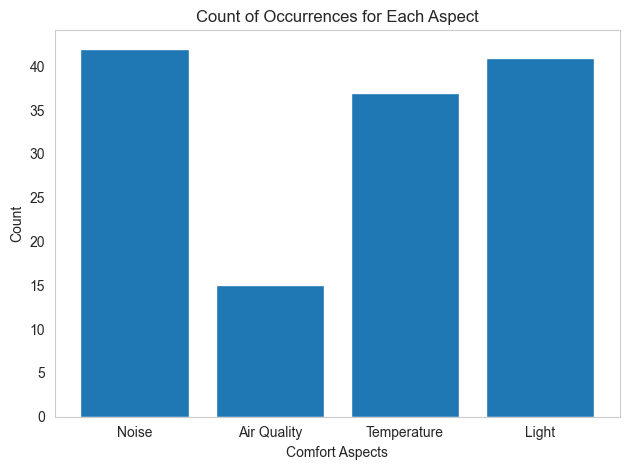

In [44]:
# Count occurrences of each aspect
aspect_counts = df[['noise', 'air', 'temperature', 'light']].apply(lambda column: column.astype(bool).sum(), axis=0)

custom_ticks = ['Noise', 'Air Quality', 'Temperature', 'Light']

# Plot the aspect occurrences
plt.bar(aspect_counts.index, aspect_counts.values)
plt.xlabel('Comfort Aspects')
plt.ylabel('Count')
plt.title('Count of Occurrences for Each Aspect')
plt.xticks(aspect_counts.index, custom_ticks)
plt.tight_layout()
plt.savefig('plots/comfort-aspect-occurances-count.jpg',
            dpi=300, bbox_inches='tight')

In [51]:
for aspect in df.columns[1:]:
    df["senti_" + aspect] = df[aspect].apply(sentiment_analysis)

In [52]:
# Initialize counters for sentiment distribution
sentiment_distribution = {
    'positive': [],
    'negative': [],
    'neutral': []
}

# Iterate through sentiment columns and extract sentiment distributions
for column in df.columns[5:]:
    sentiments = df[column]
    sentiment_count = {'positive': 0, 'negative': 0, 'neutral': 0}
    for sentiment in sentiments:
        if len(sentiment) > 0:
            label = sentiment[0]['label']
            sentiment_count[label] += 1
    sentiment_distribution['positive'].append(sentiment_count['positive'])
    sentiment_distribution['negative'].append(sentiment_count['negative'])
    sentiment_distribution['neutral'].append(sentiment_count['neutral'])

In [57]:
dist_df = pd.DataFrame(sentiment_distribution, index=df.columns[5:])
dist_df = dist_df.melt(var_name='Sentiment', value_name='Count', ignore_index=False).reset_index()
dist_df

,index,Sentiment,Count
0,senti_noise,positive,10
1,senti_air,positive,7
2,senti_temperature,positive,13
3,senti_light,positive,16
4,senti_noise,negative,9
5,senti_air,negative,2
6,senti_temperature,negative,5
7,senti_light,negative,3
8,senti_noise,neutral,23
9,senti_air,neutral,6


<Figure size 800x700 with 0 Axes>

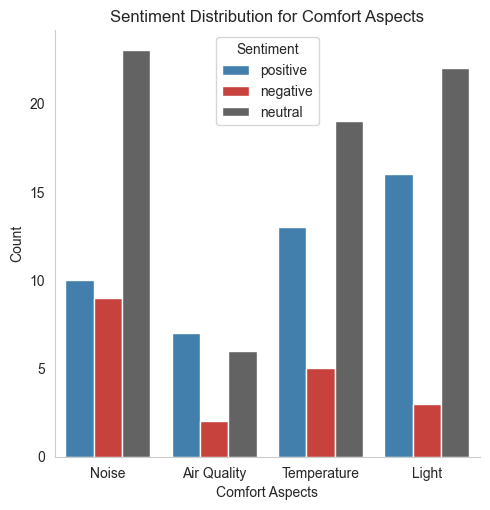

In [75]:
# Set Seaborn style
custom_ticks = ['Noise', 'Air Quality', 'Temperature', 'Light']
custom_palette = {'positive': '#3182bd',
                  'negative': '#de2d26',
                  'neutral': '#636363'}

# Create grouped bar plot using Seaborn catplot
plt.figure(figsize=(8, 7))
plot = sns.catplot(x='index',
                   y='Count',
                   hue='Sentiment',
                   data=dist_df,
                   kind='bar',
                   legend=False,
                   palette=custom_palette
                  )
plt.xlabel('Comfort Aspects')
plt.ylabel('Count')
plot.set_xticklabels(custom_ticks)
plt.title('Sentiment Distribution for Comfort Aspects')

ax = plot.ax
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[0:3], labels[0:3], title='Sentiment')

# plt.tight_layout()
plt.savefig('plots/comfort-aspect-sentiments-count.jpg',
            dpi=300, bbox_inches='tight')

### Aspect Co-Occurance

In [130]:
def calculate_cooccurance_matrix(df):
    # Initialize aspect co-occurrence matrix
    aspects = list(comfort_aspect.keys())
    co_occurrence_matrix = np.zeros((len(aspects), len(aspects)))

    print(co_occurrence_matrix)
    
    # Iterate through each text and extract mentioned aspects
    for text in df["comfort"]:
        tokenized_text = re.findall(r'\w+', text.lower())
        tokenized_text = [stemmer.stem(token) for token in tokenized_text]
        mentioned_aspects = []

        for token in tokenized_text:
            for aspect, keywords in stemmed_comfort_aspect.items():
                if token in keywords:
                    mentioned_aspects.append(aspect)

        # Increment co-occurrence counts
        for i, aspect1 in enumerate(mentioned_aspects):
            for j, aspect2 in enumerate(mentioned_aspects):
                if i != j:
                    co_occurrence_matrix[aspects.index(aspect1)][aspects.index(aspect2)] += 1


    # co_occurrence_percentages = co_occurrence_matrix / co_occurrence_matrix.sum() * 100

    return co_occurrence_matrix


def create_cooccurance_dataframe(matrix):
    co_occurrence_df = pd.DataFrame(matrix, index=aspects, columns=aspects)
    return co_occurrence_df


def plot_cooccurance_df(df):
    custom_palette = {'positive': '#3182bd',
                      'negative': '#de2d26',
                      'neutral': '#636363'}

    sns.color_palette("Blues", as_cmap=True)

    plt.figure(figsize=(10, 8))
    sns.heatmap(df, square=False)
    plt.title("Aspect Co-occurrence Matrix")
    # plt.tight_layout()
    plt.savefig('plots/comfort-aspect-co-occurance.jpg',
                dpi=300, bbox_inches='tight')

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


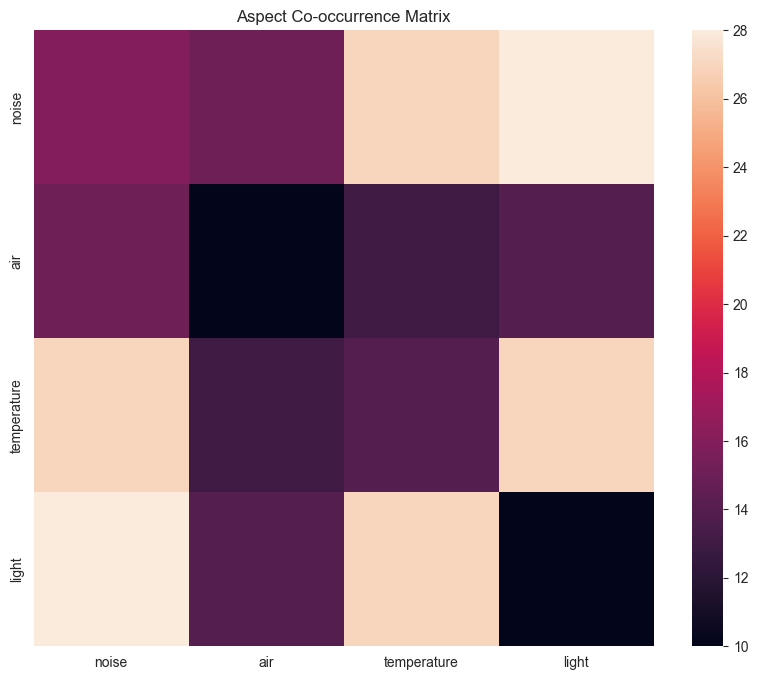

In [129]:
matrix = calculate_cooccurance_matrix(df)
cooccurance_df = create_cooccurance_dataframe(matrix)
plot_cooccurance_df(cooccurance_df)